# Naive Bayes Classification

In this notebook I will be preparing my Twitter data and performing Naive Bayes classification in order to classify tweets according to their political sentiments. I have a corpus of about 2.5 million tweets mentioning school shootings, which I obtained using the academic access Twitter API. The labels I will use to train my Naive Bayes model will come from hashtags in the tweets. I will identify some of the most common hashtags in my corpus to identify classes of interest, and I will then train a Naive Bayes algorithm to group tweets into these classes.

In [142]:
import pandas as pd
import numpy as np

# Read in twitter data
tweets = pd.read_csv('./../../../../large_data/02-clean-data/Twitter/all_tweets.tsv', sep='\t', dtype='str')

# Melt dataset so all hashtags are in one column
hashtags = tweets.set_index('Incident_ID').iloc[:,2:].melt(var_name='tag_num', value_name='tag').dropna()

# Drop tag_num column
hashtags = hashtags.drop(columns=['tag_num'])

In [143]:
# Save value counts
hashtag_counts = hashtags['tag'].value_counts()

# Print all of the hashtags with their value counts to determine classes
# for val_str, val_count in hashtag_counts.items():
#     print(val_count, val_str)

# Print a preview of the hashtags with their counts
hashtag_counts[0:10]

shooting          9754
news              8014
school            7519
gunviolence       2761
guncontrol        2567
schoolshooting    2437
guncontrolnow     2407
nra               2277
shooter           1715
parkland          1711
Name: tag, dtype: int64

While the original intent of this analysis was going to be prediction of the political standing of each tweet based on the hashtags, the value counts have shown that the data are too biased for this kind of approach. The vast majority of hashtags included in tweets are in favor of gun control, which makes sense because the tweets were queried specifically in connection to individual school shooting incidents. The majority of expressed sentiment after a tragic school shooting incident would understandably be to tighten gun laws. I believe that it is for this reason that the value counts of the hashtags are highly imbalanced, with far greater gun control sentiment over gun rights sentiment.  
  
The other issue with this approach would be the ambiguity associated with each label. If we were to treat hashtags as the labels classifying whether a tweet supports stricter or looser gun laws, it is entirely possible that a given hashtag could appear in either type of tweet. For example, a hashtag #nra may appear in a tweet that criticizes National Rifle Association (NRA) agendas or it may appear in a tweet that supports them. These biases in the data have compelled a new approach.  
  
Instead of predicting a tweet's political standing, we will instead classify tweets as "news" tweets or "opinion" tweets. The labels for this analysis will be applied based on the type of hashtags used in the tweet. Hashtag classifications are defined below.

In [144]:
news_hts = ['news', 'breakingnews']
op_hts = ['guncontrolnow', 'gunsense', 'gunreformnow', 'neveragain', 'endgunviolence', 'stopgunviolence', 'enoughisenough', 'nrabloodmoney', 'rejectthenra', 'enough', 'momsdemand']

We will need to assign labels to the tweets featuring hashtags of interest (as defined above).

In [145]:
# Define function to assign labels to tweets
def classify_tweets(tweet_hashtags):
    if any(tweet_hashtags.notna()):
        in_news_hts = any(ht in tweet_hashtags.tolist() for ht in news_hts)
        in_op_hts = any(ht in tweet_hashtags.tolist() for ht in op_hts)

        if all([in_news_hts, in_op_hts]):
            return 'news_op'
        elif in_news_hts:
            return 'news'
        elif in_op_hts:
            return 'op'
        else:
            return np.nan
    else:
        return np.nan

tweets['labels'] = tweets.iloc[:,2:35].apply(classify_tweets, axis=1)

In [146]:
tweets['labels'].value_counts()

op         21154
news       18251
news_op       82
Name: labels, dtype: int64

The ```news_op``` label represents tweets tha have hashtags from both classes in them. Impressively, there are only 82 of them. We examine the content of some of them below:

In [147]:
for txt in tweets[tweets['labels'] == 'news_op']['text'][0:5]:
    print(txt)

“We’re expected to be human shields”: Teachers are unprotected — and scared https://t.co/11ehIs3AuH #news #feedly #education #teachertwitter #GunControlNow
https://t.co/iWHyiERGYA: “We’re expected to be human shields”: #Teachers are unprotected — and scared.  #UvaldeMassacre #edutwitter #mondaythoughts #GunReformNow #NEWS  https://t.co/aznMhGPC8L
"the blood of those shootings are on your hands.”  https://t.co/kuwGKzBv6V #news #SchoolShootings #GunControlNow #NRAHasBloodOnItsHands #NRAIsATerroristOrganization
‘How Many Children Have to Die?’: School Shooting Survivors Talk Back to the NRA https://t.co/kuwGKzBv6V #news #GunControlNow #UvaldeschoolMassacre #NRAHasBloodOnItsHands #TaxTheNRA #uspoli
Enough. This has to stop. #UvaldeMassacre #UvaldeStrong #truecrime #truecrimecommunity #BREAKING #BreakingNews #Enough https://t.co/lQ3wbaiCh0


Clearly the ```news_op``` class has some tweets that fall under opinion tweets and some that fall under news tweets. Because the number of tweets in this class is so small, it won't be necessary to include them in our training dataset. Our opinion and news classes are roughly balanced, so we will proceed with the Naive Bayes classification with these data.

In [148]:
# Save all tweets with a label into new dataframe
tweets_labels = tweets[tweets['labels'].notna()][['Incident_ID', 'text', 'labels']].copy().set_index('Incident_ID')

# Omit news_op tweets
tweets_labels = tweets_labels[tweets_labels['labels'] != 'news_op']

We will now build a pipeline to preprocess the data.

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from typing import List
import string
import re

class TweetPreprocessor():
    """
    Tweet Preprocessor

    Accepts tweets and runs preprocessing on them to produce BOW models and vocabularies
    """
    vocab: dict
    bow: np.ndarray
    processed_tweets: List[str]
    
    def preprocess(self, twitter_corpus: List[str]):
        """
        Preprocess Twitter corpus
        
        Parameters
        ----------
        twitter_corpus: list of twitter strings
        """

        tknzr = TweetTokenizer(preserve_case=False, reduce_len=True)
        lmtzr = WordNetLemmatizer()
        vctrzr = CountVectorizer()
        stop_words = set(stopwords.words('english'))

        # Remove links from tweets
        corpus_nolinks = [re.sub(r"http\S+", "", twt) for twt in twitter_corpus]

        # Run tweets through NLTK's TweetTokenizer
        tweets_tknzd = [tknzr.tokenize(twt) for twt in corpus_nolinks]

        # Remove stopwords and punctuation
        tweets_tokens = [[word for word in twt if not (word in stop_words) and not (word in string.punctuation)] for twt in tweets_tknzd]

        # Lemmatize tokens and join with spaces
        tweets_processed = [" ".join([lmtzr.lemmatize(word) for word in twt]) for twt in tweets_tokens]

        # Form BOW model
        X = vctrzr.fit_transform(tweets_processed)
        bow = X.toarray()
        vocab = vctrzr.get_feature_names_out()

        # Define class attributes
        self.vocab = {word: index for index, word in enumerate(vocab)}
        self.bow = bow
        self.processed_tweets = tweets_processed

    def get_vocab(self):
        """
        Return the vocabulary of the Twitter corpus

        Returns
        -------
        dict: Keys as words and values as the index of the word in the vocabulary
        """
        return self.vocab

    def get_bow(self):
        """
        Return the Bag of Words (BOW) model of the Twitter corpus

        Returns
        -------
        ndarray: Matrix of rows as documents (tweets) and columns as words (from the vocabulary)
        """
        return self.bow

    def get_processed_tweets(self):
        """
        Return the processed tweets

        Returns
        -------
        List[str]: List of lemmatized tweets
        """
        return self.processed_tweets

# Perform train test split on labeled tweets
df_train, df_test = train_test_split(tweets_labels, test_size=0.2)

# Check label counts for training set (are they roughly equal?)
# print(df_train['labels'].value_counts())

# They are, so we will continue with the preprocessing
# Initialize preprocessor
twt_pre_train = TweetPreprocessor()
twt_pre_test = TweetPreprocessor()

# Preprocess training and testing sets
twt_pre_train.preprocess(df_train['text'])
twt_pre_test.preprocess(df_test['text'])

# Get processed testing set tweets
tweets_test_processed = twt_pre_test.get_processed_tweets()

# Get training set vocabulary
vocab_train = twt_pre_train.get_vocab()

# Get Bag of Words model for training set
bow_train = twt_pre_train.get_bow()

# Get Bag of Words model for testing set based on training set vocabulary
bow_test = np.zeros(shape = (len(tweets_test_processed), len(vocab_train)))
for i, doc in enumerate(tweets_test_processed):
    for word in doc.split():
        if (word in vocab_train.keys()): # ignore word if not in training vocab
            j = vocab_train[word]
            bow_test[i, j] += 1

Now that we have processed the tweets, we can train the Naive Bayes classifier.

In [150]:
from sklearn.naive_bayes import MultinomialNB

# Initialize model
nb = MultinomialNB()

# Train model
nb.fit(bow_train, df_train['labels'])
pred_labels = nb.predict(bow_test)

We will now analyze the performance of the Naive Bayes classifier by comparing the test set predicted labels with the true test set labels. To do this effectively, we will quickly build a Naive Bayes classifier on randomized data to serve as a baseline.

In [151]:
import random

# Define copy of list of labels to randomize
random_labels = df_train['labels'].copy().tolist()

# Randomize the list
random.shuffle(random_labels)

# Initialize baseline/randomized model
nb_rand = MultinomialNB()

# Train baseline/randomized model
nb_rand.fit(bow_train, random_labels)
pred_labels_rand = nb_rand.predict(bow_test)

Below we can see confusion matrices comparing the performance of the trained Naive Bayes model with the baseline. Each square represents a classification group that a number of tweets belongs to. Working clockwise from the top left, the squares represent: tweets that were correctly classified as "News" tweets, "News" tweets that were incorrectly classified as "Opinion" tweets, tweets that were correctly classified as "Opinion" tweets, and "Opinion" tweets that were incorreclty classified as "News" tweets.

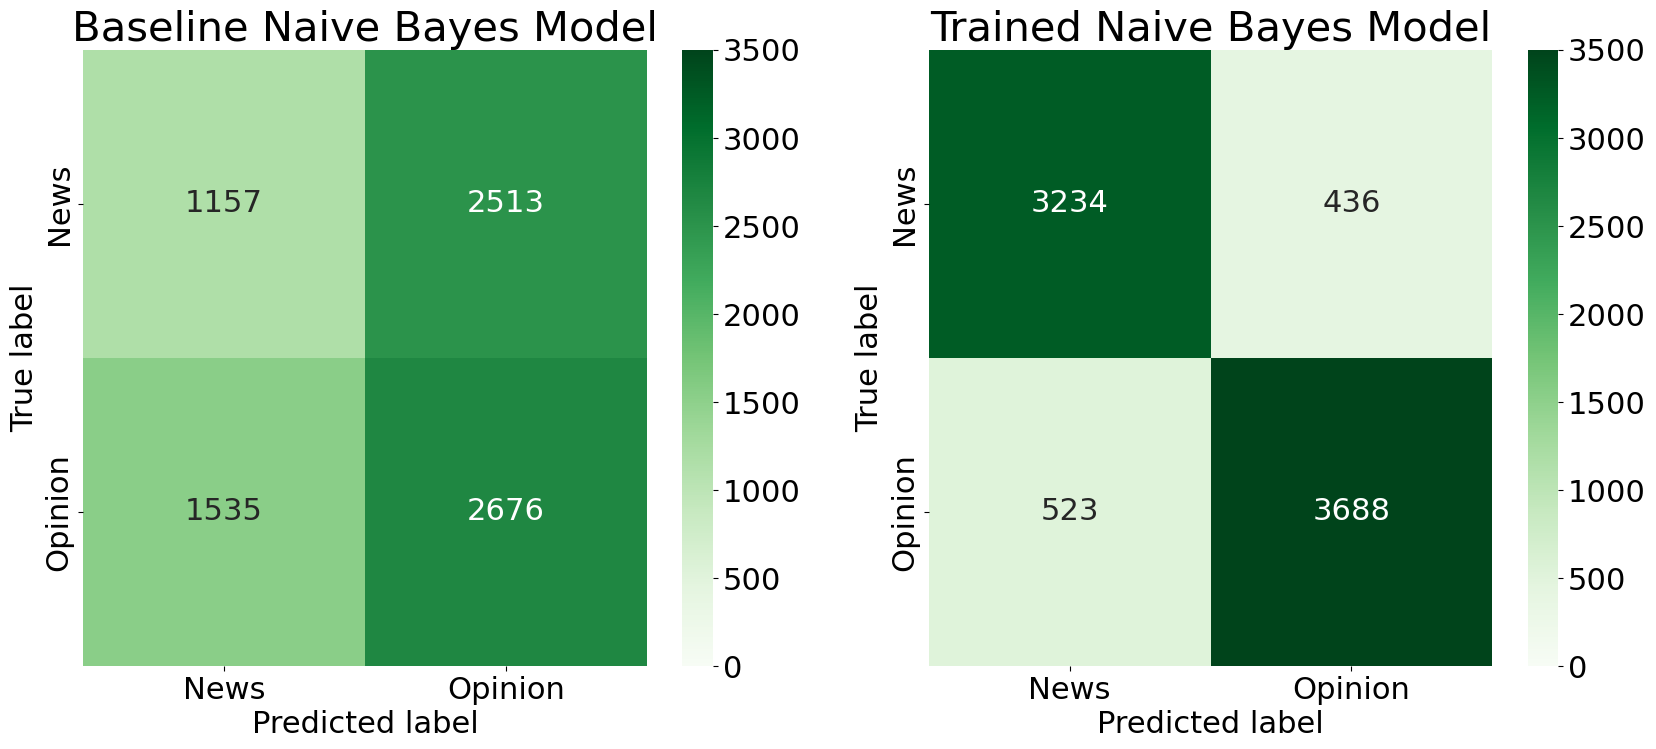

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
# Set font size
plt.rcParams.update({'font.size': 22})

cm_base = confusion_matrix(df_test['labels'], pred_labels_rand)
cm_pred = confusion_matrix(df_test['labels'], pred_labels)

figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.heatmap(cm_base, annot=True, fmt='g', ax=axes[0], vmin=0, vmax=3500, cmap='Greens')
sns.heatmap(cm_pred, annot=True, fmt='g', ax=axes[1], vmin=0, vmax=3500, cmap='Greens')

# Specify axis titles
axes[0].set_title("Baseline Naive Bayes Model", fontdict={'fontsize': 30})
axes[1].set_title("Trained Naive Bayes Model", fontdict={'fontsize': 30})

# Specify labels and ticks
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')
axes[0].xaxis.set_ticklabels(['News', 'Opinion'])
axes[0].yaxis.set_ticklabels(['News', 'Opinion'])

axes[1].set_xlabel('Predicted label')
axes[1].set_ylabel('True label')
axes[1].xaxis.set_ticklabels(['News', 'Opinion'])
axes[1].yaxis.set_ticklabels(['News', 'Opinion'])

plt.savefig('./../../../501-project-website/images/naive_bayes/confusion_matrix.png')

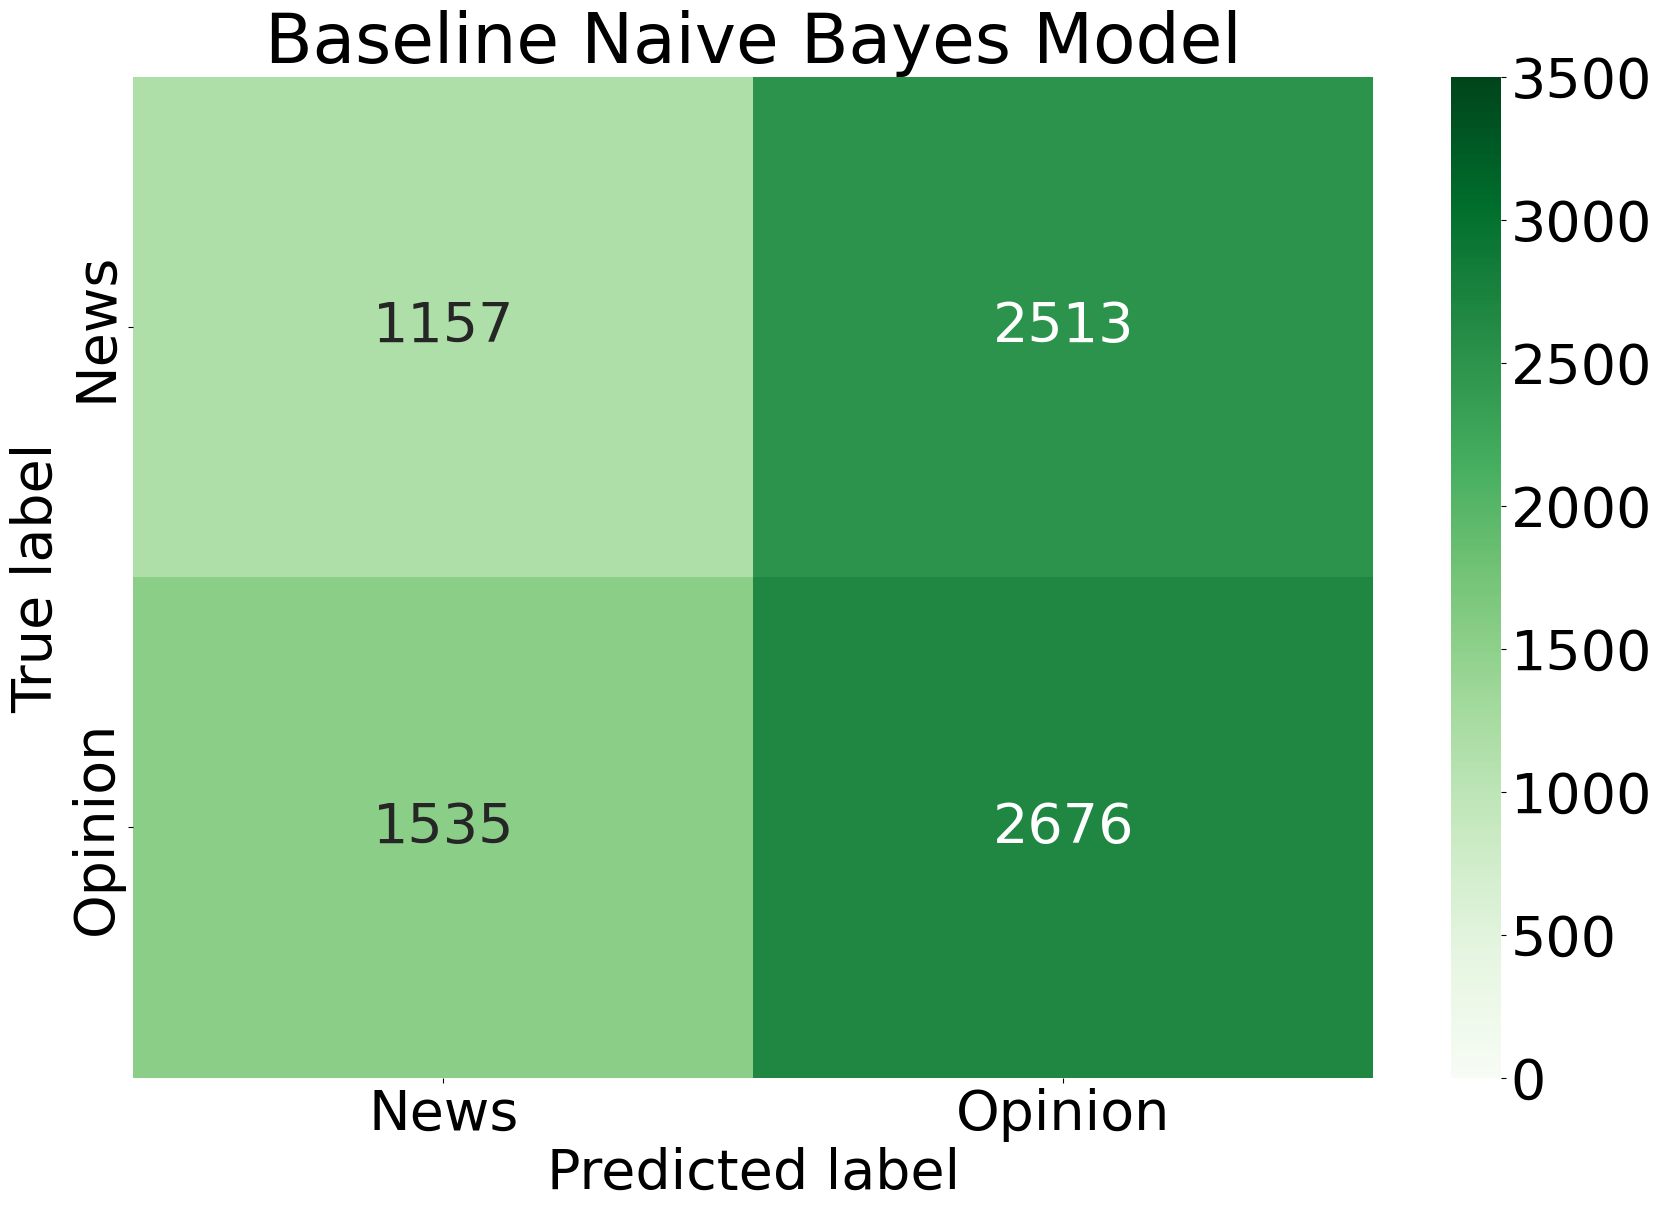

In [210]:
# Plot individual confusion matrices for website
plt.rcParams.update({'font.size': 40})

fig_baseline, ax_baseline = plt.subplots(figsize=(20, 13))

sns.heatmap(cm_base, annot=True, fmt='g', ax=ax_baseline, vmin=0, vmax=3500, cmap='Greens')

# Specify axis titles
ax_baseline.set_title("Baseline Naive Bayes Model", fontdict={'fontsize': 50})

# Specify labels and ticks
ax_baseline.set_xlabel('Predicted label')
ax_baseline.set_ylabel('True label')
ax_baseline.xaxis.set_ticklabels(['News', 'Opinion'])
ax_baseline.yaxis.set_ticklabels(['News', 'Opinion'])

plt.savefig('./../../../501-project-website/images/naive_bayes/confusion_matrix_baseline.png')

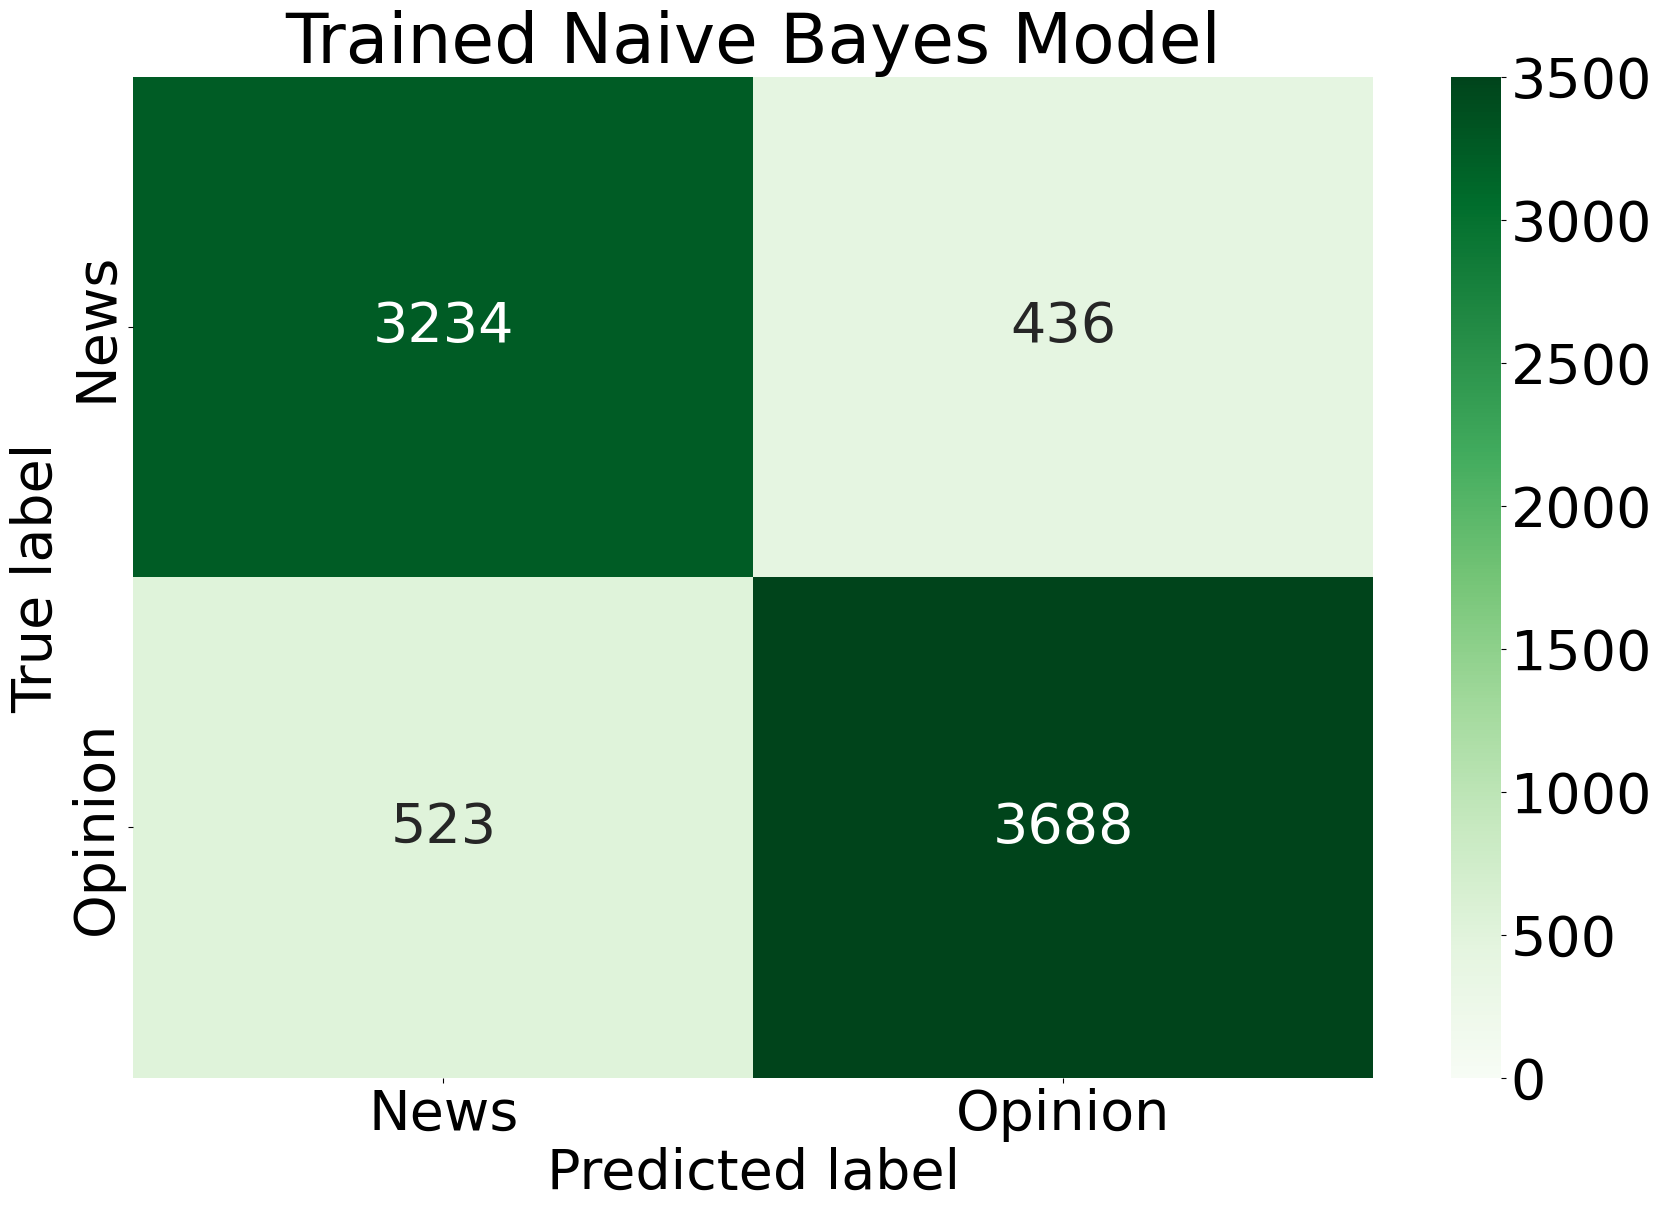

In [211]:
fig_trained, ax_trained = plt.subplots(figsize=(20, 13))

sns.heatmap(cm_pred, annot=True, fmt='g', ax=ax_trained, vmin=0, vmax=3500, cmap='Greens')

# Specify axis titles
ax_trained.set_title("Trained Naive Bayes Model", fontdict={'fontsize': 50})

# Specify labels and ticks
ax_trained.set_xlabel('Predicted label')
ax_trained.set_ylabel('True label')
ax_trained.xaxis.set_ticklabels(['News', 'Opinion'])
ax_trained.yaxis.set_ticklabels(['News', 'Opinion'])

plt.savefig('./../../../501-project-website/images/naive_bayes/confusion_matrix_trained.png')

We can also use metrics to compare the performance between the two models. The definitions of these metrics are defined as:
- **Accuracy**: The ratio of correct classifications to all classifications.
- **Precision**: The ratio of true positives to the total number of true positives and false negatives. In this case, we define the positive class as a "News" tweet. Thus, in this scenario precision represents the classifier's propensity for correctly classifying "News" tweets.
- **Recall**: The ratio of true positives to the total number of positives classified. In this case, we define the positive class as a "News" tweet. Thus, in this scenario recall represents the classifier's propensity for minimizing misclassification of "Opinion" tweets.
- **F1**: The harmonic mean between precision and recall. In this scenario, it serves as a combination between the classifier's ability to correctly classify "News" tweets while minimizing misclassification of "Opinion" tweets.


In [195]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Metric scores
# 1st element: my model, 2nd element, randomized/baseline model
col_names = ['Trained', 'Baseline']
row_names = ['Accuracy', 'Precision', 'Recall', 'F1']

accuracies = [
    accuracy_score(df_test['labels'],pred_labels),
    accuracy_score(df_test['labels'], pred_labels_rand)
]
precisions = [
    precision_score(df_test['labels'], pred_labels, pos_label='news'),
    precision_score(df_test['labels'], pred_labels_rand, pos_label='news')
]
recalls = [
    recall_score(df_test['labels'], pred_labels, pos_label='news'),
    recall_score(df_test['labels'], pred_labels_rand, pos_label='news')
]
f1s = [
    f1_score(pred_labels, df_test['labels'], average='weighted'),
    f1_score(pred_labels_rand, df_test['labels'], average='weighted')
]

pd.DataFrame(
    [accuracies, precisions, recalls, f1s],
    columns=col_names,
    index=row_names
)


,Trained,Baseline
Accuracy,0.878315,0.486360
Precision,0.860793,0.429792
Recall,0.881199,0.315259
F1,0.878237,0.499119


In conclusion, the model is quite good at classifying tweets as either "News" tweets or "Opinion" tweets. As in many machine learning algorithms, the model is only as good as its data. The use of hashtags as proxies for labels in this corpus of tweets about school shootings was certainly less than perfect, and therefore results in a poorer model.  
  
It is worth noting that this model was trained and tested exclusively on tweets with hashtags belonging to the classification dictionaries defined above. In total, this set of tweets totals to 39,405 tweets out of the total 2,485,482 tweets we retrieved using the Academic Research Twitter API. This offers an interesting opportunity to apply the model to the remaining 2.4 million tweets about school shootings, gaining insight into the variance between "Opinion" tweet frequency and "News" tweet frequency over time. This will be a point of future analysis, and will be updated here once performed.